#### Package Installation

In [8]:
# %pip install langchain-openai
# %pip install langchain-groq
# %pip install langchain-ollama
# %pip install langgraph-supervisor
# %pip install langgraph
# %pip install langchain
# %pip install langchain-core
# %pip install langchain-community
# %pip install langchain-openai
# %pip install langchain-anthropic
# %pip install langchain-google-genai
# %pip install langchain-google-genai
# %pip install langchain_experimental
# %pip install dotenv
# %pip install python-dotenv

#### Imports

In [1]:
from typing import Annotated, Dict, List, Any, Literal
from typing_extensions import TypedDict
import re
import os

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage
from langchain_core.memory import BaseMemory

from langchain_community.chat_models import ChatOllama
from langchain_groq import ChatGroq
from langchain_openai import ChatOpenAI
from langchain_ollama import ChatOllama

from langgraph.graph import MessagesState, END, StateGraph, START
from langgraph.types import Command
from langgraph.prebuilt import create_react_agent
from langgraph_supervisor import create_supervisor

from dotenv import load_dotenv

In [2]:
load_dotenv()

False

#### Initialize Models

#### Groq

In [ ]:
groq_model = ChatGroq(
    model="deepseek-r1-distill-llama-70b",
    api_key="YOUR_GROQ_API"
)
groq_model.invoke("hi").content

'<think>\n\n</think>\n\nHello! How can I assist you today?'

In [4]:
# Clean text function for Groq model
def clean_text(text):
    clean_text = re.sub(r"<think>.*?</think>\s*", "", text, flags=re.DOTALL)
    return clean_text

clean_text(groq_model.invoke("hi").content)

'Hello! How can I assist you today? 😊'

#### Ollama

In [5]:
from langchain_community.chat_models import ChatOllama
from langchain_core.messages import SystemMessage, HumanMessage

# Initialize Ollama by explicitly providing the IP address
ollama_llama = ChatOllama(
    model="llama2:7b",
    base_url="http://127.0.0.1:11434"  
)

# Define message inputs
system_message = SystemMessage(content="You are a helpful assistant.")
human_message = HumanMessage(content="What is LangChain?")

response_llama = ollama_llama.invoke([system_message, human_message])
print("Llama response:", response_llama.content)

C:\Users\Ebrahim\AppData\Local\Temp\ipykernel_1968\4282739096.py:5: LangChainDeprecationWarning: The class `ChatOllama` was deprecated in LangChain 0.3.1 and will be removed in 1.0.0. An updated version of the class exists in the :class:`~langchain-ollama package and should be used instead. To use it run `pip install -U :class:`~langchain-ollama` and import as `from :class:`~langchain_ollama import ChatOllama``.
  ollama_llama = ChatOllama(


Llama response: Ahoy there! *adjusts glasses* I'm here to help you with your query. LangChain, you say? Let me tell you all about it! 🚀

LangChain is an innovative language model that has gained popularity in recent times. It's a computer program designed to understand and generate human-like language, with a focus on creating engaging and personalized content for users. Developed by a team of experienced researcher at Meta AI, LangChain leverages the power of deep learning algorithms and natural language processing (NLP) techniques to craft unique and compelling text outputs. 🤖

So, what sets LangChain apart from other language models? For starters, it has been trained on a diverse range of texts, including literature, articles, social media posts, and even chat logs! This allows LangChain to generate responses that are not only grammatically correct but also contextually relevant. Plus, its advanced algorithms enable it to pick up on subtle cues and nuances in language, enabling it t

In [6]:
ollama_phi4= ChatOllama(model="phi4:14b")
response_phi4 = ollama_phi4.invoke([system_message, human_message])
print("phi4 response:", response_phi4.content)

phi4 response: LangChain is an open-source framework designed to facilitate the development and deployment of applications using language models, such as those provided by OpenAI or other providers like Hugging Face. Its primary goal is to make it easier for developers to build sophisticated natural language processing (NLP) applications by providing tools and abstractions that manage complex aspects of interacting with language models.

Key features of LangChain include:

1. **Modularity**: It allows developers to break down their NLP application into smaller, manageable components or "chains." Each component can handle specific tasks like input parsing, model interaction, or response generation.

2. **Integration**: LangChain supports integration with various large language models (LLMs), making it easier for users to plug in different AI services as needed. This flexibility allows developers to switch between models or use multiple ones within the same application.

3. **Tools and U

#### Adding Memory Tool

In [7]:
class State(MessagesState):
    next: str 
    project_memory: Dict[str, Any]
    current_agent: str


class ProjectMemory:
    """Simplified memory class for storing project state"""
    
    def __init__(self):
        self.requirements = []
        self.plan = ""
        self.project_management = ""
        self.use_cases = ""
        self.class_diagram = ""
        self.database_design = ""
        self.documentation = ""
        self.current_phase = "requirements"
        self.phase_done = {}    
    
    def update_requirements(self, content: str):
        """Extract requirements from content"""
        if "## Functional Requirements:" in content:
            lines = content.split('\n')
            in_functional = False
            in_nonfunctional = False
            
            for line in lines:
                line = line.strip()
                if "## Functional Requirements:" in line:
                    in_functional = True
                    in_nonfunctional = False
                    continue
                elif "## Non-Functional Requirements:" in line:
                    in_functional = False
                    in_nonfunctional = True
                    continue
                elif line.startswith('- ') and (in_functional or in_nonfunctional):
                    req = line[2:].strip()
                    if req and req not in self.requirements:
                        self.requirements.append(req)
    
    def get_context_for_agent(self, agent_name: str) -> str:
        """Get relevant context for specific agent"""
        context = ""
        
        if agent_name == "planning" and self.requirements:
            context += "\n\nAvailable Requirements:\n"
            for req in self.requirements:
                context += f"- {req}\n"
        
        elif agent_name in ["project_management", "use_case", "class_diagram", "database", "documentation"]:
            if self.requirements:
                context += "\n\nProject Requirements:\n"
                for req in self.requirements:
                    context += f"- {req}\n"
            
            if self.plan and agent_name != "planning":
                context += f"\n\nProject Plan:\n{self.plan}\n"
        
        return context


In [8]:
# Initialize global memory
project_memory = ProjectMemory()

####  Mermaid Tools

In [9]:
@tool
def create_mermaid_usecase(actors: List[str], use_cases: List[str]) -> str:
    """Create a Mermaid use case diagram"""
    diagram = "graph TD\n"
    for i, actor in enumerate(actors):
        actor_id = f"A{i}"
        diagram += f"    {actor_id}[{actor}]\n"
        for j, use_case in enumerate(use_cases):
            use_case_id = f"UC{j}"
            diagram += f"    {actor_id} --> {use_case_id}[{use_case}]\n"
    return f"```mermaid\n{diagram}```"


@tool  
def create_mermaid_class(classes: List[Dict[str, Any]]) -> str:
    """Create a Mermaid class diagram"""
    diagram = "classDiagram\n"
    for cls in classes:
        class_name = cls.get("name", "Class")
        attributes = cls.get("attributes", [])
        methods = cls.get("methods", [])
        
        diagram += f"    class {class_name} {{\n"
        for attr in attributes:
            diagram += f"        +{attr}\n"
        for method in methods:
            diagram += f"        +{method}\n"
        diagram += "    }\n"
    return f"```mermaid\n{diagram}```"

#### Identify sub agents (8 Agents)
- supervisor agent
- Requirement Analysis Agent
- Planning Agent
- Project Management Agent
- Use Case Agent
- Class Diagram Agent
- Database Design Agent
- Documentation & Reporting Agent


In [ ]:
# # Supervisor Agent with proper routing
# def supervisor_node(state: State) -> Command[Literal["requirements_analysis", "planning", "project_management", "use_case", "class_diagram", "database", "documentation", "__end__"]]:
    
#     # Get the last user message
#     last_message = state["messages"][-1].content if state["messages"] else ""
    
#     # Build context from project memory
#     memory_context = ""
#     if project_memory.requirements:
#         memory_context += "\n\nCurrent Requirements:\n"
#         for req in project_memory.requirements:
#             memory_context += f"- {req}\n"
    
#     memory_context += f"\n\nCurrent Phase: {project_memory.current_phase}"
#     if project_memory.plan:
#         memory_context += f"\n\nPlan Status: Available"
    
#     system_prompt = f"""
# You are Devistant's Supervisor Agent. You manage specialized sub-agents for software engineering projects.

# Available Sub-agents:
# - requirements_analysis: Captures and validates user requirements
# - planning: Creates project plans and task breakdowns  
# - project_management: Manages schedules and methodology
# - use_case: Develops use cases and user stories
# - class_diagram: Creates UML class diagrams
# - database: Designs database schemas
# - documentation: Creates technical documentation

# Your job:
# 1. Route user requests to the appropriate agent
# 2. Follow the logical workflow: requirements → planning → other phases
# 3. Only route to next phase when current phase is complete
# 4. Return "FINISH" when all work is complete

# Current user request: "{last_message}"

# Routing Rules:
# - If user wants requirements analysis or this is initial request: route to "requirements_analysis"
# - If user asks for plan/planning and requirements exist: route to "planning" 
# - If user asks for project management: route to "project_management"
# - If user asks for use cases: route to "use_case"
# - If user asks for class diagram: route to "class_diagram"
# - If user asks for database design: route to "database"
# - If user asks for documentation: route to "documentation"
# - If user says done/finished: return "FINISH"

# {memory_context}

# Respond with ONLY the agent name or "FINISH". No explanation needed.
# """
    
#     messages = [{"role": "system", "content": system_prompt}]
#     if state["messages"]:
#         messages.append({"role": "user", "content": str(last_message)})
#     ## HERE
#     response = groq_model.invoke([SystemMessage(content=system_prompt), 
#                                 HumanMessage(content=last_message)])
#     response_text = clean_text(response.content).strip().lower()
    
#     print(f"Supervisor received: {last_message}")
#     print(f"Supervisor response: {response_text}")
    
#     # Determine routing
#     if "finish" in response_text:
#         goto = END
#     elif "requirements_analysis" in response_text or "requirements" in response_text:
#         goto = "requirements_analysis"
#         project_memory.current_phase = "requirements"
#     elif "planning" in response_text:
#         goto = "planning"
#         project_memory.current_phase = "planning"
#     elif "project_management" in response_text or "project management" in response_text:
#         goto = "project_management"
#         project_memory.current_phase = "project_management"
#     elif "use_case" in response_text:
#         goto = "use_case"
#         project_memory.current_phase = "use_case"
#     elif "class_diagram" in response_text or "class" in response_text:
#         goto = "class_diagram"
#         project_memory.current_phase = "class_diagram"
#     elif "database" in response_text:
#         goto = "database"
#         project_memory.current_phase = "database"
#     elif "documentation" in response_text:
#         goto = "documentation"
#         project_memory.current_phase = "documentation"
#     else:
#         # Default to requirements if unclear
#         goto = "requirements_analysis"
#         project_memory.current_phase = "requirements"
    
#     print(f"Supervisor routing to: {goto}")
    
#     return Command(
#         goto=goto,
#         update={
#             "next": str(goto),
#             "current_agent": str(goto),
#             "project_memory": {
#                 "requirements": project_memory.requirements,
#                 "current_phase": project_memory.current_phase
#             }
#         }
#     )

In [31]:
# --- SUPERVISOR NODE ---
def supervisor_node(state: State) -> Command[Literal[
    "requirements_analysis", "planning", "project_management", "use_case", "class_diagram", "database", "documentation", "__end__"
]]:
    phase_order = [
        "requirements_analysis",
        "planning",
        "project_management",
        "use_case",
        "class_diagram",
        "database",
        "documentation"
    ]
    project_memory = state.get("project_memory", {})
    if "phase_done" not in project_memory:
        project_memory["phase_done"] = {phase: False for phase in phase_order}
    phase_done = project_memory["phase_done"]
    current_phase = state.get("current_agent", None)
    if current_phase in phase_order:
        phase_done[current_phase] = True
    # Find the next incomplete phase
    next_phase = None
    for phase in phase_order:
        if not phase_done.get(phase, False):
            next_phase = phase
            break
    if next_phase is None:
        goto = END
    else:
        goto = next_phase
        project_memory["current_phase"] = next_phase
    print(f"[Supervisor] phase_done: {phase_done}")
    print(f"[Supervisor] current_phase: {current_phase} -> {goto}")
    return Command(
        goto=goto,
        update={
            "next": str(goto),
            "current_agent": str(goto),
            "project_memory": project_memory
        }
    )

# --- REQUIREMENTS ANALYSIS AGENT ---
def requirements_analysis_node(state: State) -> Command[Literal["supervisor"]]:
    project_memory = state.get("project_memory", {})
    prompt = """
You are the Requirements Analysis Agent in Devistant.

Your job:
- Analyze the user's project idea thoroughly
- Extract clear functional and non-functional requirements
- Structure requirements in a clear, actionable format
- Be comprehensive but concise

Format your response as:
## Functional Requirements:
- [Requirement 1]
- [Requirement 2]
...

## Non-Functional Requirements:  
- [Requirement 1]
- [Requirement 2]
...

Then end with: "Requirements analysis complete. Ready for planning phase."
"""

    user_message = ...  # extract from state["messages"]
    messages = [
        SystemMessage(content=prompt),
        HumanMessage(content=f"Analyze this project request: {user_message}")
    ]
    response = ollama_phi4.invoke(messages)
    response_content = response.content  # <-- Make sure this is present!
    project_memory["requirements"] = response_content  # Or parse as needed
    return Command(
        update={
            "messages": [AIMessage(content=response_content, name="requirements_analysis")],
            "current_agent": "requirements_analysis",
            "project_memory": project_memory
        },
        goto="supervisor"
    )

# --- PLANNING AGENT ---
def planning_node(state: State) -> Command[Literal["supervisor"]]:
    project_memory = state.get("project_memory", {})
    context = ""
    prompt = f"""
You are the Planning Agent in Devistant.

Your responsibilities:
- Convert approved requirements into a prioritized task breakdown
- Categorize tasks by development phases (Frontend, Backend, Database, Testing, Deployment)
- Provide estimated complexity for each task (Simple/Medium/Complex)
- Create an actionable development roadmap

{context}

Create a structured development plan with clear phases and tasks.
End with: "Development plan complete. Ready for project management phase."
"""
    messages = [
        SystemMessage(content=prompt),
        HumanMessage(content="Create a development plan based on the analyzed requirements.")
    ]
    response = ollama_llama.invoke(messages)
    response_content = response.content
    project_memory["plan"] = response_content
    return Command(
        update={
            "messages": [AIMessage(content=response_content, name="planning")],
            "current_agent": "planning",
            "project_memory": project_memory
        },
        goto="supervisor"
    )

# --- PROJECT MANAGEMENT AGENT ---
def project_management_node(state: State) -> Command[Literal["supervisor"]]:
    project_memory = state.get("project_memory", {})
    context = ""
    prompt = f"""
You are the Project Management Agent for Devistant.

You handle:
- Choosing methodology (Agile/Waterfall) based on project characteristics
- Breaking tasks into sprints (if Agile) or phases (if Waterfall)
- Creating timeline with milestones and delivery targets
- Suggesting team roles and responsibilities

{context}

Create a project management plan with methodology, timeline, and team structure.
"""
    messages = [
        SystemMessage(content=prompt),
        HumanMessage(content="Create a project management plan based on the development plan.")
    ]
    response = ollama_phi4.invoke(messages)
    response_content = response.content
    project_memory["project_management"] = response_content
    return Command(
        update={
            "messages": [AIMessage(content=response_content, name="project_management")],
            "current_agent": "project_management",
            "project_memory": project_memory
        },
        goto="supervisor"
    )

# --- USE CASE AGENT ---
def use_case_node(state: State) -> Command[Literal["supervisor"]]:
    project_memory = state.get("project_memory", {})
    context = ""
    prompt = f"""
You are the Use Case Agent in Devistant.

Your job:
- Create user stories and use cases based on requirements
- Output in natural language and Mermaid diagram format
- Map each use case to functional requirements
- Include actors, steps, and postconditions

{context}

Create comprehensive use cases with Mermaid diagrams.
"""
    messages = [
        SystemMessage(content=prompt),
        HumanMessage(content="Create use cases and user stories based on the requirements.")
    ]
    response = ollama_phi4.invoke(messages)
    response_content = response.content
    project_memory["use_cases"] = response_content
    return Command(
        update={
            "messages": [AIMessage(content=response_content, name="use_case")],
            "current_agent": "use_case",
            "project_memory": project_memory
        },
        goto="supervisor"
    )

# --- CLASS DIAGRAM AGENT ---
def class_diagram_node(state: State) -> Command[Literal["supervisor"]]:
    project_memory = state.get("project_memory", {})
    context = ""
    prompt = f"""
You are the Class Diagram Agent for Devistant.

Your task:
- Analyze requirements and use cases to design object-oriented class structure
- Output suggested classes with attributes and methods
- Generate Mermaid class diagram showing relationships
- Follow OOP best practices (encapsulation, inheritance, etc.)

{context}

Create a comprehensive class diagram with explanations.
"""
    messages = [
        SystemMessage(content=prompt),
        HumanMessage(content="Design class structure based on the use cases and requirements.")
    ]
    response = ollama_llama.invoke(messages)
    response_content = response.content
    project_memory["class_diagram"] = response_content
    return Command(
        update={
            "messages": [AIMessage(content=response_content, name="class_diagram")],
            "current_agent": "class_diagram",
            "project_memory": project_memory
        },
        goto="supervisor"
    )

# --- DATABASE AGENT ---
def database_node(state: State) -> Command[Literal["supervisor"]]:
    project_memory = state.get("project_memory", {})
    context = ""
    prompt = f"""
You are the Database Design Agent for Devistant.

You:
- Recommend suitable database type (SQL/NoSQL/etc)
- Design database schema with proper relationships
- Output Mermaid Entity-Relationship diagram
- Include tables, primary/foreign keys, and data types

{context}

Create a comprehensive database design with ER diagram.
"""
    messages = [
        SystemMessage(content=prompt),
        HumanMessage(content="Design database schema based on the class structure and requirements.")
    ]
    response = ollama_phi4.invoke(messages)
    response_content = response.content
    project_memory["database_design"] = response_content
    return Command(
        update={
            "messages": [AIMessage(content=response_content, name="database")],
            "current_agent": "database",
            "project_memory": project_memory
        },
        goto="supervisor"
    )

# --- DOCUMENTATION AGENT ---
def documentation_node(state: State) -> Command[Literal["supervisor"]]:
    project_memory = state.get("project_memory", {})
    prompt = f"""
You are the Documentation Agent in Devistant.

Your tasks:
- Summarize all agent outputs in structured documentation
- Create professional, exportable project documentation
- Include all phases: requirements, planning, management, use cases, design, database
- Format for both technical and non-technical readers

Available project information:
Requirements: {len(project_memory.get('requirements', []))} items
Plan: {"Available" if  project_memory.get('plan') else "Not available"}
Project Management: {"Available" if project_memory.get('project_management') else "Not available"}
Use Cases: {"Available" if project_memory.get('use_case') else "Not available"}
Class Diagram: {"Available" if project_memory.get('class_diagram') else "Not available"}
Database Design: {"Available" if project_memory.get('database_design') else "Not available"}

Create comprehensive project documentation.
"""
    messages = [
        SystemMessage(content=prompt),
        HumanMessage(content="Create final project documentation summarizing all work done.")
    ]
    response = ollama_phi4.invoke(messages)
    response_content = response.content
    project_memory["documentation"] = response_content
    return Command(
        update={
            "messages": [AIMessage(content=response_content, name="documentation")],
            "current_agent": "documentation",
            "project_memory": project_memory
        },
        goto="supervisor"
    )

In [ ]:
# # Requirements Analysis Agent
# def requirements_analysis_node(state: State) -> Command[Literal["supervisor"]]:
    
#     prompt = """
# You are the Requirements Analysis Agent in Devistant.

# Your job:
# - Analyze the user's project idea thoroughly
# - Extract clear functional and non-functional requirements
# - Structure requirements in a clear, actionable format
# - Be comprehensive but concise

# Format your response as:
# ## Functional Requirements:
# - [Requirement 1]
# - [Requirement 2]
# ...

# ## Non-Functional Requirements:  
# - [Requirement 1]
# - [Requirement 2]
# ...

# Then end with: "Requirements analysis complete. Ready for planning phase."
# """
    
#     # Get user's original request
#     user_message = ""
#     for msg in state["messages"]:
#         if msg.type == "human":
#             user_message = msg.content
#             break
    
#     messages = [
#         SystemMessage(content=prompt),
#         HumanMessage(content=f"Analyze this project request: {user_message}")
#     ]
    
#     response = ollama_phi4.invoke(messages)
#     response_content = response.content
    
#     # Update project memory
#     project_memory.update_requirements(str(response_content))
    
#     print(f"Requirements Agent processed {len(project_memory.requirements)} requirements")
    
#     return Command(
#         update={
#             "messages": [AIMessage(content=response_content, name="requirements_analysis")],
#             "current_agent": "requirements_analysis"
#         },
#         goto="supervisor"
#     )

In [ ]:
# # Planning Agent  
# def planning_node(state: State) -> Command[Literal["supervisor"]]:
    
#     # Get context from memory
#     context = project_memory.get_context_for_agent("planning")
    
#     prompt = f"""
# You are the Planning Agent in Devistant.

# Your responsibilities:
# - Convert approved requirements into a prioritized task breakdown
# - Categorize tasks by development phases (Frontend, Backend, Database, Testing, Deployment)
# - Provide estimated complexity for each task (Simple/Medium/Complex)
# - Create an actionable development roadmap

# {context}

# Create a structured development plan with clear phases and tasks.
# End with: "Development plan complete. Ready for project management phase."
# """
    
#     messages = [
#         SystemMessage(content=prompt),
#         HumanMessage(content="Create a development plan based on the analyzed requirements.")
#     ]
    
#     response = ollama_llama.invoke(messages)
#     response_content = response.content
    
#     # Store plan in memory
#     project_memory.plan = str(response_content)
    
#     print("Planning Agent created development plan")
    
#     return Command(
#         update={
#             "messages": [AIMessage(content=response_content, name="planning")],
#             "current_agent": "planning"
#         },
#         goto="supervisor"
#     )

In [ ]:
# # Project Management Agent
# def project_management_node(state: State) -> Command[Literal["supervisor"]]:
    
#     context = project_memory.get_context_for_agent("project_management")
    
#     prompt = f"""
# You are the Project Management Agent for Devistant.

# You handle:
# - Choosing methodology (Agile/Waterfall) based on project characteristics
# - Breaking tasks into sprints (if Agile) or phases (if Waterfall)
# - Creating timeline with milestones and delivery targets
# - Suggesting team roles and responsibilities

# {context}

# Create a project management plan with methodology, timeline, and team structure.
# """
    
#     messages = [
#         SystemMessage(content=prompt),
#         HumanMessage(content="Create a project management plan based on the development plan.")
#     ]
    
#     response = ollama_phi4.invoke(messages)
#     response_content = response.content
    
#     project_memory.project_management = str(response_content)
    
#     return Command(
#         update={
#             "messages": [AIMessage(content=response_content, name="project_management")],
#             "current_agent": "project_management"
#         },
#         goto="supervisor"
#     )


In [ ]:
# # Use Case Agent with Mermaid
# def use_case_node(state: State) -> Command[Literal["supervisor"]]:
    
#     context = project_memory.get_context_()
#     requirements_text = "\n".join([f"- {req}" for req in context["requirements"]])
    
#     prompt = f"""You are the Use Case Agent.

# Based on requirements:
# {requirements_text}

# Create:
# ## User Stories:
# - As a [user], I want [feature] so that [benefit]

# ## Use Cases:
# ### Use Case 1: [Title]
# - Actor: [User type]
# - Steps: 1. Action 2. Response

# Then create a simple Mermaid diagram."""
    
#     use_case_agent = create_react_agent(
#         ollama_phi4, 
#         tools=[create_mermaid_usecase], 
#         system_prompt=prompt
#     )
    
#     result = use_case_agent.invoke(state)
#     content = result["messages"][-1].content if result["messages"] else ""
    
#     project_memory.save_output("use_case", content)
    
#     return Command(
#         update={"messages": [HumanMessage(content=content, name="use_case_agent")],
#         "current_agent": "use_case_agent"},
#         goto="supervisor"
#     )


In [ ]:
# # Class Diagram Agent with Mermaid
# def class_diagram_node(state: State) -> Command[Literal["supervisor"]]:
    
#     context = project_memory.get_context()
    
#     prompt = f"""You are the Class Diagram Agent.

# Design classes based on the use cases and requirements.

# Format:
# ## Classes:
# ### Class 1: [Name]
# - Attributes: attr1, attr2
# - Methods: method1(), method2()

# Create a Mermaid class diagram."""
    
#     class_agent = create_react_agent(
#         ollama_llama,
#         tools=[create_mermaid_class],
#         system_prompt=prompt
#     )
    
#     result = class_agent.invoke(state)
#     content = result["messages"][-1].content if result["messages"] else ""
    
#     project_memory.save_output("class_diagram", content)
    
#     return Command(
#         update={"messages": [HumanMessage(content=content, name="class_diagram_agent")],
#         "current_agent": "class_diagram_agent"},
#         goto="supervisor"
#     )


In [ ]:

# # Use Case Agent
# def use_case_node(state: State) -> Command[Literal["supervisor"]]:
    
#     context = project_memory.get_context_for_agent("use_case")
    
#     prompt = f"""
# You are the Use Case Agent in Devistant.

# Your job:
# - Create user stories and use cases based on requirements
# - Output in natural language and Mermaid diagram format
# - Map each use case to functional requirements
# - Include actors, steps, and postconditions

# {context}

# Create comprehensive use cases with Mermaid diagrams.
# """
    
#     messages = [
#         SystemMessage(content=prompt),
#         HumanMessage(content="Create use cases and user stories based on the requirements.")
#     ]
    
#     response = ollama_phi4.invoke(messages)
#     response_content = response.content
    
#     project_memory.use_cases = response_content
    
#     return Command(
#         update={
#             "messages": [AIMessage(content=response_content, name="use_case")],
#             "current_agent": "use_case"
#         },
#         goto="supervisor"
#     )

In [ ]:
# # Class Diagram Agent
# def class_diagram_node(state: State) -> Command[Literal["supervisor"]]:
    
#     context = project_memory.get_context_for_agent("class_diagram")
    
#     prompt = f"""
# You are the Class Diagram Agent for Devistant.

# Your task:
# - Analyze requirements and use cases to design object-oriented class structure
# - Output suggested classes with attributes and methods
# - Generate Mermaid class diagram showing relationships
# - Follow OOP best practices (encapsulation, inheritance, etc.)

# {context}

# Create a comprehensive class diagram with explanations.
# """
    
#     messages = [
#         SystemMessage(content=prompt),
#         HumanMessage(content="Design class structure based on the use cases and requirements.")
#     ]
    
#     response = ollama_llama.invoke(messages)
#     response_content = response.content
    
#     project_memory.class_diagram = response_content
    
#     return Command(
#         update={
#             "messages": [AIMessage(content=response_content, name="class_diagram")],
#             "current_agent": "class_diagram"
#         },
#         goto="supervisor"
#     )

In [ ]:
# # Database Agent
# def database_node(state: State) -> Command[Literal["supervisor"]]:
    
#     context = project_memory.get_context_for_agent("database")
    
#     prompt = f"""
# You are the Database Design Agent for Devistant.

# You:
# - Recommend suitable database type (SQL/NoSQL/etc)
# - Design database schema with proper relationships
# - Output Mermaid Entity-Relationship diagram
# - Include tables, primary/foreign keys, and data types

# {context}

# Create a comprehensive database design with ER diagram.
# """
    
#     messages = [
#         SystemMessage(content=prompt),
#         HumanMessage(content="Design database schema based on the class structure and requirements.")
#     ]
    
#     response = ollama_phi4.invoke(messages)
#     response_content = response.content
    
#     project_memory.database_design = response_content
    
#     return Command(
#         update={
#             "messages": [AIMessage(content=response_content, name="database")],
#             "current_agent": "database"
#         },
#         goto="supervisor"
#     )


In [ ]:
# # Documentation Agent
# def documentation_node(state: State) -> Command[Literal["supervisor"]]:
    
#     prompt = f"""
# You are the Documentation Agent in Devistant.

# Your tasks:
# - Summarize all agent outputs in structured documentation
# - Create professional, exportable project documentation
# - Include all phases: requirements, planning, management, use cases, design, database
# - Format for both technical and non-technical readers

# Available project information:
# Requirements: {len(project_memory.requirements)} items
# Plan: {"Available" if project_memory.plan else "Not available"}
# Project Management: {"Available" if project_memory.project_management else "Not available"}
# Use Cases: {"Available" if project_memory.use_cases else "Not available"}
# Class Diagram: {"Available" if project_memory.class_diagram else "Not available"}
# Database Design: {"Available" if project_memory.database_design else "Not available"}

# Create comprehensive project documentation.
# """
    
#     messages = [
#         SystemMessage(content=prompt),
#         HumanMessage(content="Create final project documentation summarizing all work done.")
#     ]
    
#     response = ollama_phi4.invoke(messages)
#     response_content = response.content
    
#     project_memory.documentation = response_content
    
#     return Command(
#         update={
#             "messages": [AIMessage(content=response_content, name="documentation")],
#             "current_agent": "documentation"
#         },
#         goto="supervisor"
#     )


In [32]:
# Build the graph
graph = StateGraph(State)

# Add all nodes
graph.add_node("supervisor", supervisor_node)
graph.add_node("requirements_analysis", requirements_analysis_node)
graph.add_node("planning", planning_node)
graph.add_node("project_management", project_management_node)
graph.add_node("use_case", use_case_node)
graph.add_node("class_diagram", class_diagram_node)
graph.add_node("database", database_node)
graph.add_node("documentation", documentation_node)

# Set entry point
graph.add_edge(START, "supervisor")

# Compile the graph
app = graph.compile()

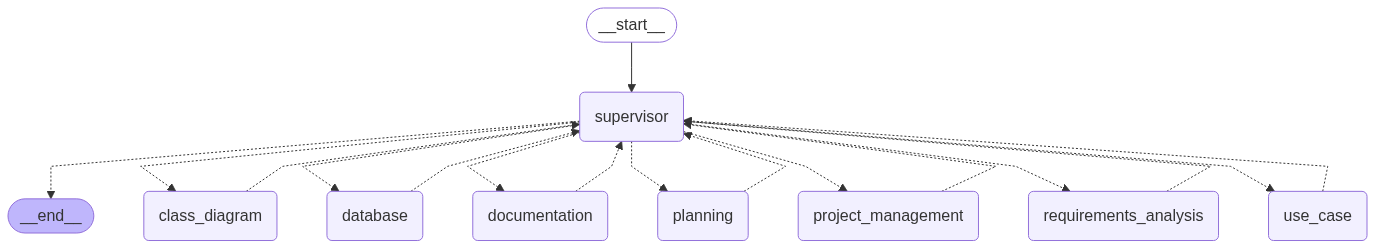

In [33]:
from IPython.display import display, Image

display(Image(app.get_graph().draw_mermaid_png()))

#### Testing

In [30]:
# # Supervisor Agent with phase-based routing

# def supervisor_node(state: State) -> Command[Literal["requirements_analysis", "planning", "project_management", "use_case", "class_diagram", "database", "documentation", "__end__"]]:
#     # Define the SDLC phase order
#     phase_order = [
#         "requirements_analysis",
#         "planning",
#         "project_management",
#         "use_case",
#         "class_diagram",
#         "database",
#         "documentation"
#     ]
#     # Get the current phase/agent
#     current_phase = state.get("current_agent", "requirements_analysis")
#     try:
#         next_index = phase_order.index(current_phase) + 1
#         if next_index < len(phase_order):
#             goto = phase_order[next_index]
#         else:
#             goto = END
#     except ValueError:
#         goto = "requirements_analysis"
#     print(f"Supervisor routing from {current_phase} to: {goto}")
#     return Command(
#         goto=goto,
#         update={
#             "next": str(goto),
#             "current_agent": str(goto),
#             "project_memory": {
#                 "requirements": project_memory.requirements,
#                 "current_phase": goto
#             }
#         }
#     )

In [ ]:
# def supervisor_node(state: State) -> Command[Literal[
#     "requirements_analysis", "planning", "project_management", "use_case", "class_diagram", "database", "documentation", "__end__"
# ]]:
#     phase_order = [
#         "requirements_analysis",
#         "planning",
#         "project_management",
#         "use_case",
#         "class_diagram",
#         "database",
#         "documentation"
#     ]

#     if isinstance(state, dict):
#         if "project_memory" not in state:
#             state["project_memory"] = ProjectMemory()  # or a dict
#         project_memory = state["project_memory"]
#     else:
#         if not hasattr(state, "project_memory"):
#             state.project_memory = ProjectMemory()
#         project_memory = state.project_memory

#     # Initialize phase_done if not present
#     if isinstance(project_memory, dict):
#         if "phase_done" not in project_memory:
#             project_memory["phase_done"] = {phase: False for phase in phase_order}
#         phase_done = project_memory["phase_done"]
#     else:
#         if not hasattr(project_memory, "phase_done"):
#             project_memory.phase_done = {phase: False for phase in phase_order}
#         phase_done = project_memory.phase_done

#     # Mark the current phase as done
#     current_phase = getattr(state, "current_agent", None) or state.get("current_agent", None)
#     if current_phase in phase_order:
#         phase_done[current_phase] = True

#     # Find the next incomplete phase
#     next_phase = None
#     for phase in phase_order:
#         if not phase_done.get(phase, False):
#             next_phase = phase
#             break

#     if next_phase is None:
#         goto = END
#     else:
#         goto = next_phase
#         if isinstance(project_memory, dict):
#             project_memory["current_phase"] = next_phase
#         else:
#             project_memory.current_phase = next_phase

#     print(f"Supervisor routing from {current_phase} to: {goto}")
#     return Command(
#         goto=goto,
#         update={
#             "next": str(goto),
#             "current_agent": str(goto),
#             "project_memory": {
#                 "requirements": getattr(project_memory, "requirements", []) if not isinstance(project_memory, dict) else project_memory.get("requirements", []),
#                 "current_phase": getattr(project_memory, "current_phase", None) if not isinstance(project_memory, dict) else project_memory.get("current_phase", None),
#                 "phase_done": phase_done
#             }
#         }
#     )

In [34]:
# Optimized One-Shot SDLC: Single Workflow with Progress Tracking

import time

def run_optimized_sdlc(project_description):
    """
    Run complete SDLC in one shot with progress tracking and optimized output
    """
    print("Starting Optimized SDLC Workflow...")
    print(f"Project: {project_description}")
    print("=" * 80)
    
    start_time = time.time()

    initial_state = {
    "messages": [HumanMessage(content=project_description)],
    "project_memory": {},  
    "current_agent": "requirements_analysis"
}
    # Single app.invoke call - let supervisor handle all routing
    result = app.invoke(initial_state)
    
    total_time = time.time() - start_time
    print(f"\n⏱️ Total execution time: {total_time:.2f} seconds")
    print("=" * 80)
    
    # Process and display results
    phase_count = 0
    for msg in result["messages"]:
        # Skip the initial human message
        if msg.type == "human":
            continue
            
        phase_count += 1
        agent_name = getattr(msg, 'name', None)
        
        if agent_name:
            print(f"\n Phase {phase_count}: {agent_name.upper()}")
        else:
            print(f"\n Phase {phase_count}: {msg.type.upper()}")
        
        print("-" * 60)
        print(msg.content)
        print("=" * 80)
    
    print(f"\n✅ SDLC Complete! Processed {phase_count} phases in {total_time:.2f} seconds")
    return result

# Run the optimized workflow
project_description = "I want to build a comprehensive e-learning platform with video courses, user progress tracking, quizzes, and a payment system for premium content"

result = run_optimized_sdlc(project_description)

Starting Optimized SDLC Workflow...
Project: I want to build a comprehensive e-learning platform with video courses, user progress tracking, quizzes, and a payment system for premium content
[Supervisor] phase_done: {'requirements_analysis': True, 'planning': False, 'project_management': False, 'use_case': False, 'class_diagram': False, 'database': False, 'documentation': False}
[Supervisor] current_phase: requirements_analysis -> planning
[Supervisor] phase_done: {'requirements_analysis': True, 'planning': True, 'project_management': False, 'use_case': False, 'class_diagram': False, 'database': False, 'documentation': False}
[Supervisor] current_phase: planning -> project_management
[Supervisor] phase_done: {'requirements_analysis': True, 'planning': True, 'project_management': True, 'use_case': False, 'class_diagram': False, 'database': False, 'documentation': False}
[Supervisor] current_phase: project_management -> use_case
[Supervisor] phase_done: {'requirements_analysis': True, 'p

Task supervisor with path ('__pregel_pull', 'supervisor') wrote to unknown channel branch:to:__end__, ignoring it.


[Supervisor] phase_done: {'requirements_analysis': True, 'planning': True, 'project_management': True, 'use_case': True, 'class_diagram': True, 'database': True, 'documentation': True}
[Supervisor] current_phase: documentation -> __end__

⏱️ Total execution time: 1118.90 seconds

 Phase 1: PLANNING
------------------------------------------------------------
As the Planning Agent in Devistant, I have carefully reviewed the approved requirements and identified the following prioritized task breakdown for the development of our new product:

**Frontend Development**

1. User Interface Design (Simple)
	* Create wireframes and mockups for each page of the application
	* Develop a consistent and intuitive UI design
2. Responsive Design (Medium)
	* Ensure the application is responsive on different devices and screen sizes
	* Implement CSS media queries to adapt the layout based on device size
3. Interactive Components (Complex)
	* Develop interactive components such as dropdown menus, modal 

In [ ]:
# # Optimized One-Shot SDLC: Single Workflow with Progress Tracking

# import time

# def run_optimized_sdlc(project_description):
#     """
#     Run complete SDLC in one shot with progress tracking and optimized output
#     """
#     print("�� Starting Optimized SDLC Workflow...")
#     print(f"Project: {project_description}")
#     print("=" * 80)
    
#     start_time = time.time()
    
#     # Single app.invoke call - let supervisor handle all routing
#     result = app.invoke({
#         "messages": [HumanMessage(content=project_description)]
#     })
    
#     total_time = time.time() - start_time
#     print(f"\n⏱️ Total execution time: {total_time:.2f} seconds")
#     print("=" * 80)
    
#     # Process and display results - FIXED to capture all agent outputs
#     phase_count = 0
#     agent_outputs = []
    
#     for msg in result["messages"]:
#         # Skip only the initial human message, capture ALL agent outputs
#         if msg.type == "human":
#             continue
            
#         phase_count += 1
#         agent_name = getattr(msg, 'name', None)
        
#         if agent_name:
#             print(f"\n�� Phase {phase_count}: {agent_name.upper()}")
#         else:
#             print(f"\n�� Phase {phase_count}: {msg.type.upper()}")
        
#         print("-" * 60)
#         print(msg.content)
#         print("=" * 80)
        
#         # Store agent output for debugging
#         agent_outputs.append({
#             'phase': phase_count,
#             'name': agent_name or msg.type,
#             'content': msg.content
#         })
    
#     print(f"\n✅ SDLC Complete! Processed {phase_count} phases in {total_time:.2f} seconds")
    
#     # Debug: Show what agents were actually processed
#     print(f"\n🔍 Debug: Agents processed:")
#     for output in agent_outputs:
#         print(f"  - Phase {output['phase']}: {output['name']}")
    
#     return result

# # Run the optimized workflow
# project_description = "I want to build a comprehensive e-learning platform with video courses, user progress tracking, quizzes, and a payment system for premium content"

# result = run_optimized_sdlc(project_description)